In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import regex as re
from textstat.textstat import textstat
from textblob import TextBlob
from spellchecker import SpellChecker
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import torch
import transformers
from transformers import pipeline
import itertools
from sklearn.model_selection import cross_val_score

In [37]:
sns.set_theme(style="whitegrid")

# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

df = pd.read_json(
    "chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [38]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [39]:
# Extracting the prompt
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

In [ ]:
# Add columns to separate responses from the conversation
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

In [ ]:
# Define model for sentiment analysis
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analysis = pipeline("sentiment-analysis", model=model_checkpoint)

#Analyze sentiment for prompt and responses
#Takes over an hour to run
#df'prompt_sentiment'] = df['prompt'].apply(lambda x: sentiment_analysis(x[:100]))
#df['response_a_sentiment'] = df['model_a_response'].apply(lambda x: sentiment_analysis(x[:100]))
#df['response_b_sentiment'] = df['model_b_response'].apply(lambda x: sentiment_analysis(x[:100]))

In [ ]:
#Export df containing sentiment scores to a json file
#df.to_json('sentiment_scores.json', orient='records', lines=True)

#### Establishing a "winner" column to display the outcome of the competition between model a and model b.

In [40]:
df['winner_name'] = np.where(
    df['winner'] == 'model_a', df['model_a'],
    np.where(
        df['winner'] == 'model_b', df['model_b'],
        np.where(
            df['winner'] == 'tie(bothbad)', 'tie(bothbad)',
            df['model_a'] + ' & ' + df['model_b']))
)

In [41]:
# Create one-hot encodings for the winning chatbot model
# This will attribute a value of 1 to the model if that model wins or there is a tie(bothgood), otherwise (model loses or tie both bad), it gives it a 0

df['one_hot_a'] = np.where(
    (df['winner'] == 'model_a') | (df['winner'] == 'tie'), 1, 0)

df['one_hot_b'] = np.where(
    (df['winner'] == 'model_b') | (df['winner'] == 'tie'), 1, 0)


In [43]:
# Create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() # Assess statistics of prompt length
df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


<Axes: xlabel='prompt_length', ylabel='Count'>

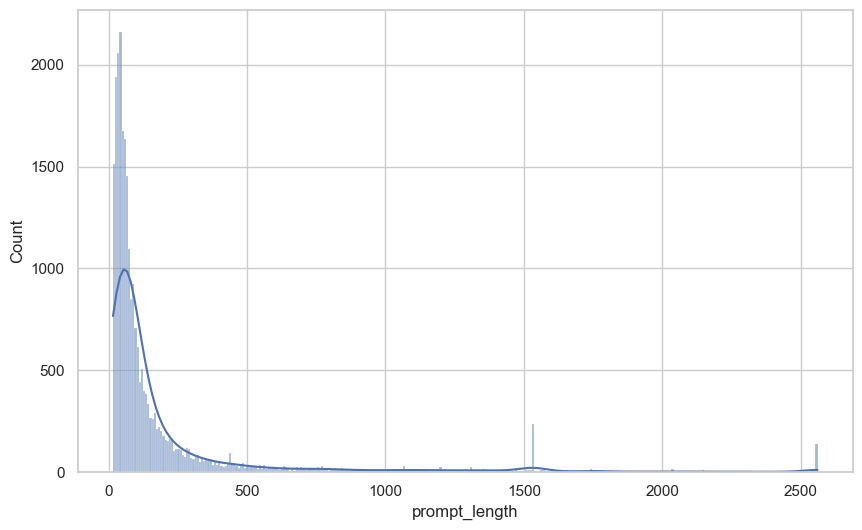

In [44]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

In [45]:
# Descriptional statistics for the response lengths and prompts
df["response_b_length"].describe()
df["response_b_length"].median()
df["response_b_length"].unique()
df["response_a_length"].describe()
df["response_a_length"].median()
df["response_a_length"].unique()

df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

Text(0, 0.5, 'Count')

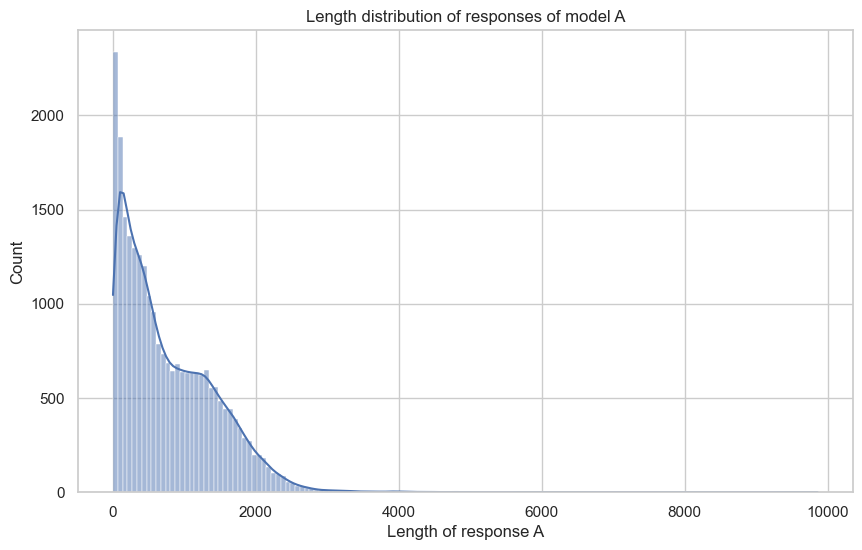

In [46]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["response_a_length"], kde=True)
plt.title("Length distribution of responses of model A")
plt.xlabel("Length of response A")
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

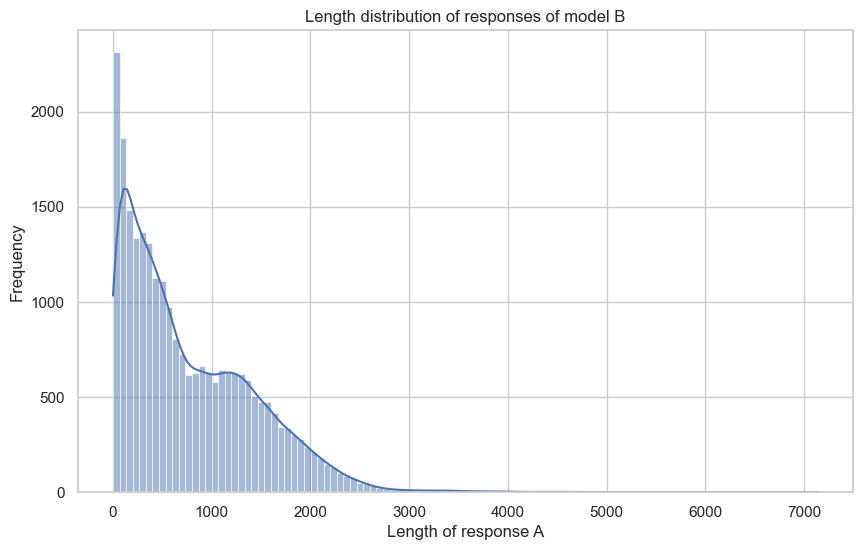

In [47]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["response_b_length"], kde=True)
plt.title("Length distribution of responses of model B")
plt.xlabel("Length of response A")
plt.ylabel("Frequency")

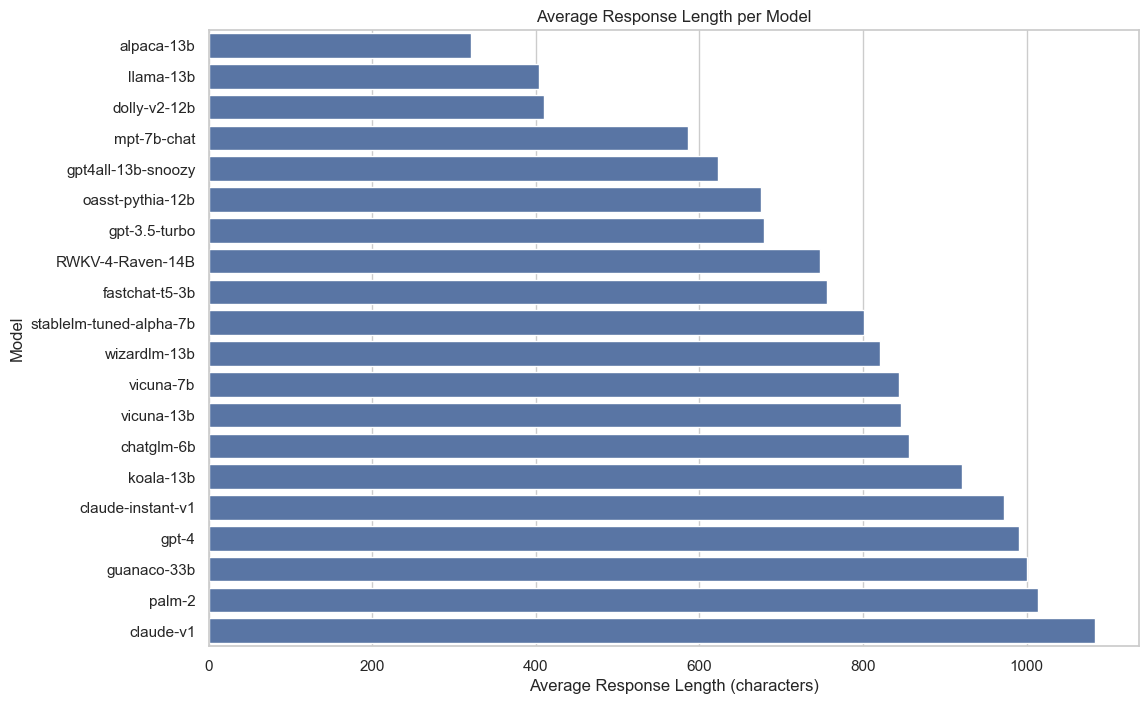

In [48]:
# Visualizing the average response lengths between models
# Stack the response lengths and models into one DataFrame
stacked_df = pd.concat([
    filtered_df[['model_a', 'response_a_length']].rename(columns={'model_a': 'model', 'response_a_length': 'response_length'}),
    filtered_df[['model_b', 'response_b_length']].rename(columns={'model_b': 'model', 'response_b_length': 'response_length'})
])

# Calculate average response length per model
model_avg_response_length = stacked_df.groupby('model')['response_length'].mean().sort_values()

# Plot the average response length per model
plt.figure(figsize=(12, 8))
sns.barplot(x=model_avg_response_length.values, y=model_avg_response_length.index)
plt.title("Average Response Length per Model")
plt.xlabel("Average Response Length (characters)")
plt.ylabel("Model")
plt.show()

In [49]:
#assigns a numerical value to the name of the winning chatbot
#this might be helpful for one hot encodings - if not we can take it out later

#create function to assign numerical values to unique names
def unique_name_ids(names):
    # Create an empty list to store unique names
    unique_names = set()

    # Split names at the & and strip whitespace
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        unique_names.update(parts)  # Add unique parts to the set

    # map names to unique id numbers
    name_to_id = {name: idx for idx, name in enumerate(unique_names)}

    # store list of ids and names
    ids = []
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        name_ids = [name_to_id[part] for part in parts]
        ids.append(name_ids)

    return ids

# Apply the function to create a new column
df['winner_name_id'] = unique_name_ids(df['winner_name'])

### Engineering feature of dot product similarity between embeddings

In [50]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]


#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [51]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [52]:
topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [53]:
# Merge the mean value of the hardness scores, as well as the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

In [54]:
nan_rows = topic_and_hardness[topic_and_hardness['hardness_score'].isna()]
nan_rows['prompt']
print(len(nan_rows))

59


In [55]:
# Removing question ids that produce null values and storing the final dataset into filtered_df

filtered_df = merged_df.dropna(subset=['hardness_score'])

#### Exploring the topic modeling and hardness score datasets

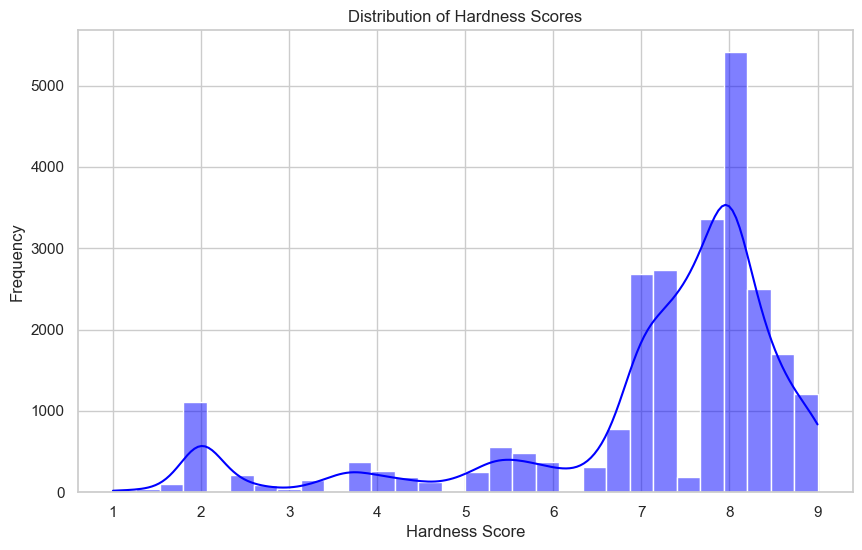

In [56]:
# Plot the hardness score distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["hardness_score"], bins=30, kde=True, color="blue")
plt.title("Distribution of Hardness Scores")
plt.xlabel("Hardness Score")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'Amount of topics with that frequency')

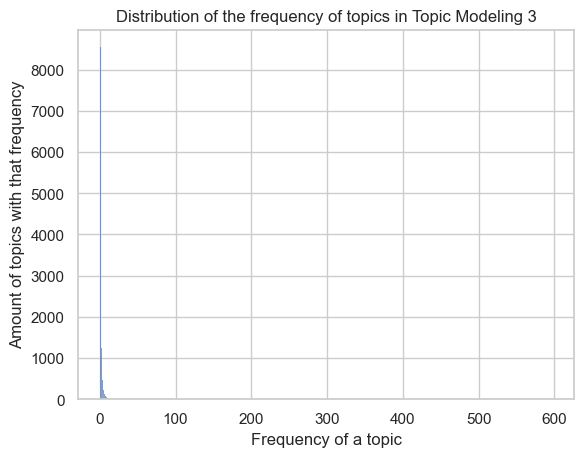

In [57]:
# Count the unique topics and plot a histogram
topic3_counts=merged_df["topic_modeling_3"].value_counts()
topic3_counts
sns.histplot(topic3_counts, binwidth=1)
plt.title("Distribution of the frequency of topics in Topic Modeling 3")
plt.xlabel("Frequency of a topic")
plt.ylabel("Amount of topics with that frequency")

In [58]:
# Count unique topics
len(topic3_counts)

# Get the most frequently occurring topics
topic3_counts[0:30]

topic_modeling_3
Creative Writing                     596
Factual Accuracy                     487
Problem-solving, Creativity          407
Factual Knowledge                    314
Problem Solving                      290
Math Problem                         206
Information Retrieval                197
Problem-solving, Factual accuracy    174
Problem-Solving, Creativity          158
Creativity, Humor                    145
Decision Making                      113
Logic Puzzle                         105
Problem-Solving                      102
Creativity, Factual Accuracy          89
Creativity, Problem-solving           87
Mathematical Calculation              81
Philosophical Inquiry                 80
Comparison Analysis                   74
Factual Recall                        74
Problem-Solving, Factual Accuracy     74
Geography Knowledge                   72
Language Translation                  72
Creative Thinking                     72
Travel Planning                       72

### Create Topic Feature

In [64]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'fact\w*': 'topic_fact',
    r'creativ\w*': 'topic_creative',
    r'problem[ -]?solving': 'topic_problem_solving',
    r'comparison': 'comparison'          # Matches "comparison"
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

# Check the updated DataFrame
filtered_df.head()

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/1128250345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/1128250345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/v

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,winner_name_id,similarity_prompt_response_a,similarity_prompt_response_b,hardness_score,topic_modeling_3,topic_math,topic_fact,topic_creative,topic_problem_solving,comparison
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,[16],1.0,0.853198,8.666667,"Comparison, Technology",0,0,0,0,1
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,"[10, 19]",1.0,0.540338,8.333333,"Reasoning, Emotional",0,0,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,[10],1.0,0.851614,3.333333,Photography comparison,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,[10],1.0,0.918109,8.000000,Chatbot Arena,0,0,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,[5],1.0,0.352887,2.000000,Time-based Inquiry,0,0,0,0,0


### Plot Topic Distribution

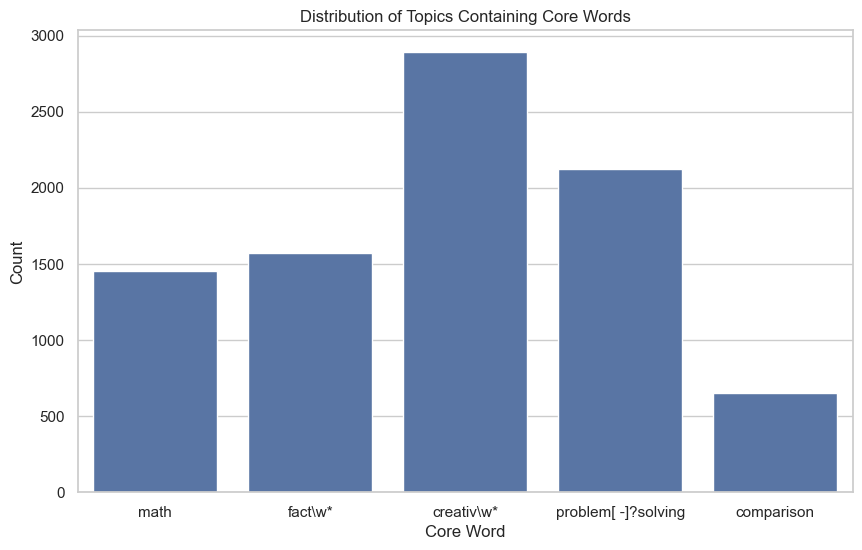

In [65]:
# Calculate topic distribution using regex
topic_distribution = {
    core_topic: (
        merged_df['topic_modeling_3'].str.contains(core_topic, flags=re.IGNORECASE, na=False, regex=True).sum()
    )
    for core_topic in core_topics
}
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(topic_distribution.keys()), y=list(topic_distribution.values()))
plt.title("Distribution of Topics Containing Core Words")
plt.xlabel("Core Word")
plt.ylabel("Count")
plt.show()


#### Calculating the ELO ratings per model:

In [66]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)




ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.295292
10                    gpt-4  1250.321864
11                claude-v1  1235.336695
19              guanaco-33b  1124.800975
9             gpt-3.5-turbo  1112.354364
3                vicuna-13b  1109.173648
14                   palm-2  1073.732764
2                 koala-13b  1069.405551
16                vicuna-7b  1050.647481
17             wizardlm-13b   997.282860
13              mpt-7b-chat   969.323150
12         RWKV-4-Raven-14B   936.973934
5                alpaca-13b   928.746627
18       gpt4all-13b-snoozy   926.126606
0                chatglm-6b   888.680752
1          oasst-pythia-12b   884.588399
4   stablelm-tuned-alpha-7b   840.143122
8            fastchat-t5-3b   827.112558
6                 llama-13b   773.676275
7              dolly-v2-12b   709.277081


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in task A (predicting whether model a or model b will win)

In [67]:
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

# Display the first few rows to verify the new column
filtered_df.columns

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/403063721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(


Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'winner_name',
       'one_hot_a', 'one_hot_b', 'model_a_response', 'model_b_response',
       'prompt_length', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'topic_math', 'topic_fact', 'topic_creative', 'topic_problem_solving',
       'comparison', 'elo_modela_minus_modelb'],
      dtype='object')

## Auxiliary verbs feature

In [68]:

# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/757170161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/757170161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/v

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,model_b_response_contains_can,model_b_response_contains_could,model_b_response_contains_may,model_b_response_contains_might,model_b_response_contains_shall,model_b_response_contains_should,model_b_response_contains_will,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,1,0,0,0,0,0,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,0,1,0,0,0,0,0,1,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,0,0,1,0,0,0,1,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,1,1,0,0,0,1,1,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Question words feature

# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,0,0,0,0,0,1,0,0,0,0


### Explore effects of auxiliary verbs & question words on winning model and hardness score

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/2407115322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model_a_has_auxiliary'] = filtered_df[auxiliary_verb_columns].any(axis=1).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_148/2407115322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model_b_has_auxiliary'] = filtered_df[auxiliary_verb_columns_b].any(axis=1).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_

<Figure size 1000x600 with 0 Axes>

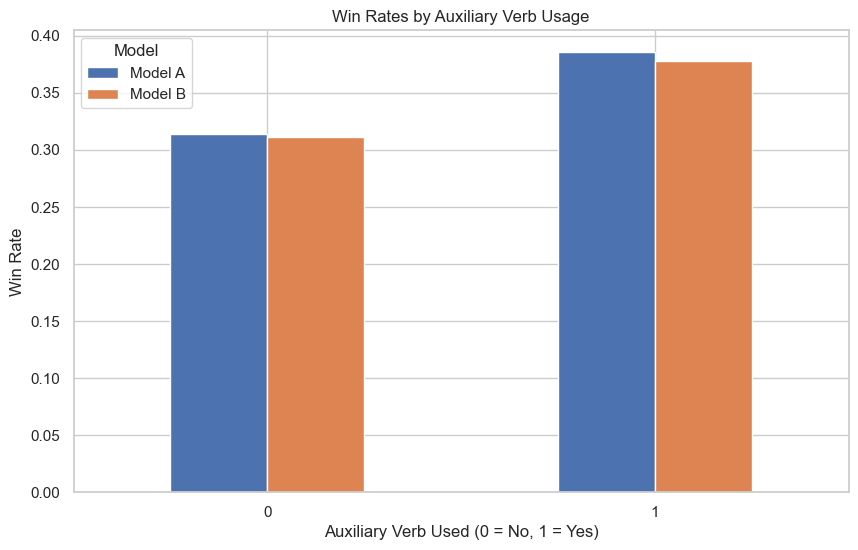

In [74]:
# Plot the effect of any auxiliary verb usage on whether the model wins
# Ensure seaborn style
sns.set(style="whitegrid")

# Check if auxiliary verb columns exist
auxiliary_verb_columns = [col for col in filtered_df.columns if '_contains_' in col and 'model_a_response' in col]

# Add a column to determine whether any auxiliary verb is present in the response
filtered_df['model_a_has_auxiliary'] = filtered_df[auxiliary_verb_columns].any(axis=1).astype(int)

# Repeat for model_b
auxiliary_verb_columns_b = [col for col in filtered_df.columns if '_contains_' in col and 'model_b_response' in col]
filtered_df['model_b_has_auxiliary'] = filtered_df[auxiliary_verb_columns_b].any(axis=1).astype(int)

# Define a column to represent the winning model
# Adjust the column name as per  dataset
filtered_df['model_a_wins'] = (filtered_df['winner'] == 'model_a').astype(int)
filtered_df['model_b_wins'] = (filtered_df['winner'] == 'model_b').astype(int)

# Calculate win rates for responses with and without auxiliary verbs
auxiliary_win_rates = {
    'Model A': filtered_df.groupby('model_a_has_auxiliary')['model_a_wins'].mean(),
    'Model B': filtered_df.groupby('model_b_has_auxiliary')['model_b_wins'].mean()
}
auxiliary_win_df = pd.DataFrame(auxiliary_win_rates)

# Visualize the win rates
plt.figure(figsize=(10, 6))
auxiliary_win_df.plot(kind='bar', figsize=(10, 6))
plt.title('Win Rates by Auxiliary Verb Usage')
plt.xlabel('Auxiliary Verb Used (0 = No, 1 = Yes)')
plt.ylabel('Win Rate')
plt.legend(title='Model')
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x600 with 0 Axes>

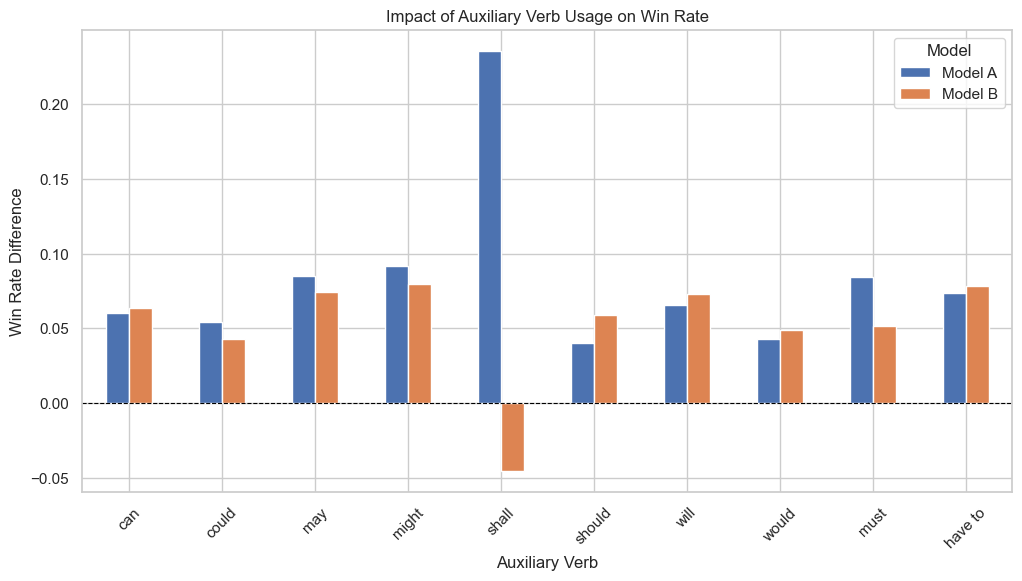

In [75]:
# Plot the effect of auxiliary verbs (modal verbs) on winning model

# Initialize dictionaries to store results
model_a_win_diff = {}
model_b_win_diff = {}

# Calculate win rate differences for each auxiliary verb
for verb in modal_verbs:
    # Regex pattern to match the auxiliary verb (case insensitive)
    pattern = rf'\b{verb}\b'
    
    # Model A: Rows where the auxiliary verb is used and not used
    model_a_with_verb = filtered_df[filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]
    model_a_without_verb = filtered_df[~filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]
    
    # Model B: Rows where the auxiliary verb is used and not used
    model_b_with_verb = filtered_df[filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]
    model_b_without_verb = filtered_df[~filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]
    
    # Calculate win rates for with and without the auxiliary verb
    model_a_win_rate_with = model_a_with_verb['winner'].eq('model_a').mean()
    model_a_win_rate_without = model_a_without_verb['winner'].eq('model_a').mean()
    model_b_win_rate_with = model_b_with_verb['winner'].eq('model_b').mean()
    model_b_win_rate_without = model_b_without_verb['winner'].eq('model_b').mean()
    
    # Store the difference in win rates
    model_a_win_diff[verb] = model_a_win_rate_with - model_a_win_rate_without
    model_b_win_diff[verb] = model_b_win_rate_with - model_b_win_rate_without

# Create a DataFrame for visualization
win_diff_df = pd.DataFrame({
    'Model A': model_a_win_diff,
    'Model B': model_b_win_diff
})

# Plot the win rate differences
plt.figure(figsize=(12, 6))
win_diff_df.plot(kind='bar', figsize=(12, 6))
plt.title('Impact of Auxiliary Verb Usage on Win Rate')
plt.xlabel('Auxiliary Verb')
plt.ylabel('Win Rate Difference')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a baseline at 0
plt.show()


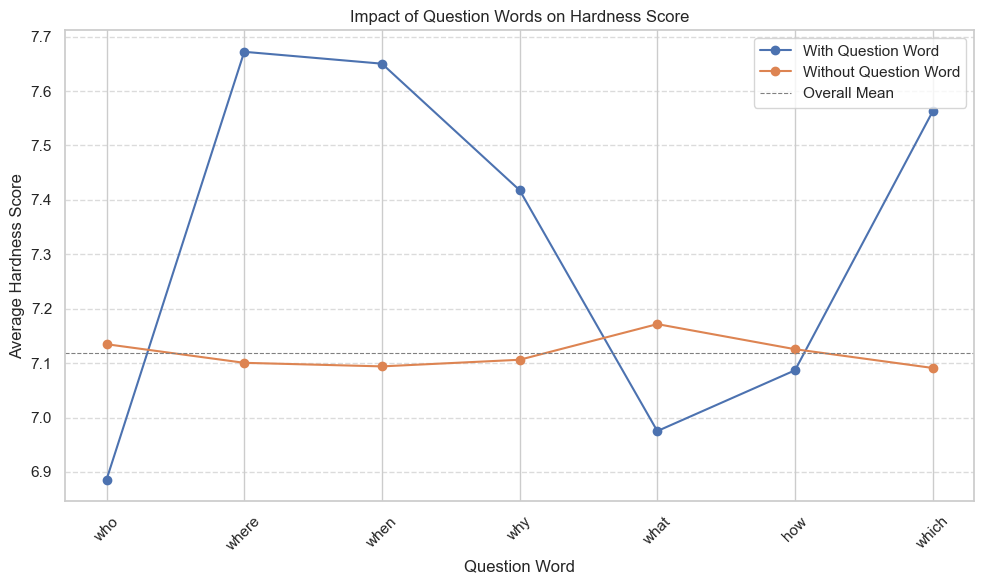

In [76]:
# Plot the effect of question words on hardness score

# Initialize a dictionary to store average hardness scores
hardness_scores = {'With': [], 'Without': []}

# Calculate the average hardness score for prompts with and without each question word
for word in question_words:
    column_name = f'prompt_contains_{word}'
    with_word = filtered_df[filtered_df[column_name] == 1]['hardness_score'].mean()
    without_word = filtered_df[filtered_df[column_name] == 0]['hardness_score'].mean()
    hardness_scores['With'].append(with_word)
    hardness_scores['Without'].append(without_word)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(question_words, hardness_scores['With'], marker='o', label='With Question Word')
plt.plot(question_words, hardness_scores['Without'], marker='o', label='Without Question Word')
plt.title('Impact of Question Words on Hardness Score')
plt.xlabel('Question Word')
plt.ylabel('Average Hardness Score')
plt.xticks(rotation=45)
plt.axhline(filtered_df['hardness_score'].mean(), color='gray', linestyle='--', linewidth=0.8, label='Overall Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [21]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'winner_name',
       'one_hot_a', 'one_hot_b', 'model_a_response', 'model_b_response',
       'prompt_length', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb', 'topic_math', 'topic_fact', 'topic_creative',
       'topic_problem_solving', 'model_a_response_contains_can',
       'model_a_response_contains_could', 'model_a_response_contains_may',
       'model_a_response_contains_might', 'model_a_response_contains_shall',
       'model_a_response_contains_should', 'model_a_response_contains_will',
       'model_a_response_contains_would', 'model_a_response_contains_must',
       'model_a_response_contains_have_to', 'model_b_response_contains_can',
       'model_b_response_contains_could', 'model_b_response_contains_

In [22]:
filtered_df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,winner_name,one_hot_a,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,koala-13b,0,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,oasst-pythia-12b & alpaca-13b,1,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,oasst-pythia-12b,0,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,vicuna-13b,1,...,0,0,0,0,0,1,0,0,0,0


## Task A

In [ ]:
# Load sentiment data
#This is the same as the conversation data set with added sentiment columns for prompt and response

sentiment_df = pd.read_json(
    "sentiment_scores.json.zip",
    lines=True,
    compression="zip"
)

In [ ]:
# convert names of models a and b to one hot encodings
categories = [
    'RWKV-4-Raven-14B', 'alpaca-13b', 'chatglm-6b', 'claude-instant-v1', 'claude-v1',
    'dolly-v2-12b', 'fastchat-t5-3b', 'gpt-3.5-turbo', 'gpt-4', 'gpt4all-13b-snoozy',
    'guanaco-33b', 'koala-13b', 'llama-13b', 'mpt-7b-chat', 'oasst-pythia-12b',
    'palm-2', 'stablelm-tuned-alpha-7b', 'vicuna-13b', 'vicuna-7b', 'wizardlm-13b', 'tie', 'tie(bothbad)'
]

one_hot_dict = {}

for idx, category in enumerate(categories):
    one_hot_vector = [0] * len(categories)
    one_hot_vector[idx] = 1
    one_hot_dict[category] = ''.join(map(str, one_hot_vector))

#add a new column that displays the name of the winning chatbot model (or tie)
sentiment_df['winner_model'] = np.where(
    sentiment_df['winner'] == 'model_b', sentiment_df['model_b'],
    np.where(
        sentiment_df['winner'] == 'model_a', sentiment_df['model_a'],
        np.where(
            sentiment_df['winner'] == 'tie', 'tie', 'tie(bothbad)'
        )
    )
)

#replace model names in model_a and model_b with onehot encodings
sentiment_df['winner_model'] = sentiment_df['winner_model'].map(one_hot_dict)

In [ ]:
# Find cosine similarity of prompt embeddings
response_a_prompt_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_b_prompt_similarity = np.array([
    cosine_similarity(response_b_embeddings[i].reshape(1, -1), prompt_embeddings[i].reshape(1, -1))[0, 0]
    for i in range(len(sentiment_df))
])
response_ab_similarity = np.array([
    cosine_similarity(response_a_embeddings[i].reshape(1,-1), response_b_embeddings[i].reshape(1, -1))[0,0]
    for i in range(len(sentiment_df))
])

# Create feature columns for each similarity analysis
sentiment_df['a_prompt_text_similarity'] = response_a_prompt_similarity
sentiment_df['b_prompt_text_similarity'] = response_b_prompt_similarity
sentiment_df['ab_text_similarity'] = response_ab_similarity

In [ ]:
def process_sentiment(sentiment):
  """
  Extracts the numeric score from a sentiment dictionary and checks for negative sentiment.

  Parameters
  ----------
  - 'score' (float): The numeric score representing the sentiment.
  - 'label' (str): The sentiment label (Positive or Negative).

  Returns
  -------
  - 'score' (float): The numeric score representing the sentiment.
  """
  sentiment_dict = sentiment[0]
  score = sentiment_dict['score']
  if sentiment_dict['label'] == 'NEGATIVE':
      return -score
  return score

# Apply function to each sentiment column
sentiment_df['prompt_sentiment_score'] = sentiment_df['prompt_sentiment'].apply(process_sentiment)
sentiment_df['response_a_sentiment_score'] = sentiment_df['response_a_sentiment'].apply(process_sentiment)
sentiment_df['response_b_sentiment_score'] = sentiment_df['response_b_sentiment'].apply(process_sentiment)

# Drop original sentiment columns
sentiment_df.drop(columns=['prompt_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_a_sentiment'], inplace=True)
sentiment_df.drop(columns=['response_b_sentiment'], inplace=True)

In [ ]:
#check for any null values in sentiment columns
sentiment_df[['prompt_sentiment_score', 'response_a_sentiment_score', 'response_b_sentiment_score']].isna().sum()

In [ ]:
#create features with the difference in sentiment scores between model a and b and between prompt and responses
sentiment_df["prompt_a_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_a_sentiment_score"]
sentiment_df["prompt_b_sentiment_diff"] = sentiment_df["prompt_sentiment_score"] - sentiment_df["response_b_sentiment_score"]
sentiment_df["ab_sentiment_diff"] = sentiment_df["response_a_sentiment_score"] - sentiment_df["response_b_sentiment_score"]

In [ ]:
def contains_negation(response, target_words):
  """
  Function to iterate over each row to search for presence of each negation word in the search_words list.

  Parameters
  ----------
  - List of negation words to search for in the response.
  - String: Response to search through.

  Returns
  -------
  - Series of binary encodings indicating presence of each search word in each response.

  """
  response = response.lower()  # Convert the response to lowercase
  for word in search_words:
    if word.lower() in response:
      return 1
  return 0

# Define search words
search_words = ["can't", "won't", "will not", "cannot", "sorry"]

# Apply function to each response
sentiment_df["response_a_contains_negation"] = sentiment_df["model_a_response"].apply(
    lambda x: contains_negation(x, search_words)
)
sentiment_df["response_b_contains_negation"] = sentiment_df["model_b_response"].apply(
    lambda x: contains_negation(x, search_words)
)

In [ ]:
#Apply modal verbs function to sentiment df

# Apply function to response columns
sentiment_df = encode_modal_verbs(sentiment_df, 'model_a_response', 'model_b_response', modal_verbs)

In [ ]:
#search for "for example" in responses
def encode_examples(df, model_a_col, model_b_col):
  """
  Function to iterate over each row in dataframe and searches for presence of an example in each response.

  Parameters
  ----------
  - String: Response A: first response to a given prompt in each row
  - String: Response B: second response to a given prompt in each row

  Returns
  -------
  - List: binary encodings indicating presence of example in response A
  - List: binary encodings indicating presence of example in response B
  """
  example_pattern = r'\bfor example\b'
  df['contains_example_a'] = df[model_a_col].str.contains(example_pattern, case=False, na=False).astype(int)
  df['contains_example_b'] = df[model_b_col].str.contains(example_pattern, case=False, na=False).astype(int)
  return df

# Apply function to response columns
sentiment_df = encode_examples(sentiment_df, 'model_a_response', 'model_b_response')

In [ ]:
#create features to analyze readability of each response with textstat
sentiment_df['response_a_readability'] = sentiment_df['model_a_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['response_b_readability'] = sentiment_df['model_b_response'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
sentiment_df['prompt_readability'] = sentiment_df['prompt'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

#calculate the difference in response readability
sentiment_df['response_readability_diff'] = sentiment_df['response_a_readability'] - sentiment_df['response_b_readability']

In [ ]:
#create columns for prompt and response lengths
sentiment_df["prompt_length"] = sentiment_df["prompt"].str.len()
sentiment_df["response_a_length"] = sentiment_df["model_a_response"].str.len()
sentiment_df["response_b_length"] = sentiment_df["model_b_response"].str.len()


In [ ]:
#create features to compare prompt and each response length as well as lengths of responses a and b
sentiment_df["prompt_minus_response_a_length"] = sentiment_df["prompt_length"] - sentiment_df["response_a_length"]
sentiment_df["prompt_minus_response_b_length"] = sentiment_df["prompt_length"] - sentiment_df["response_b_length"]
sentiment_df["response_a_minus_response_b_length"] = sentiment_df["response_a_length"] - sentiment_df["response_b_length"]

In [ ]:
# Initialize Elo ratings for all models
elo_ratings = {model: 1000 for model in pd.concat([sentiment_df["model_a"], sentiment_df["model_b"]]).unique()}

def calculate_elo_ratings(df, k=32):
    """
    Calculate and update Elo ratings for model_a and model_b for each row.

    Args:
        df (pd.DataFrame): DataFrame containing 'model_a', 'model_b', and 'winner' columns.
        k (int): The K-factor to control the adjustment magnitude.

    Returns:
        pd.DataFrame: Updated DataFrame with Elo ratings for model_a and model_b at each row.
    """
    # Create columns to store Elo ratings
    df['model_a_elo'] = 0.0
    df['model_b_elo'] = 0.0

    # Loop through rows
    for idx, row in df.iterrows():
        model_a = row['model_a']
        model_b = row['model_b']
        winner = row['winner']

        # Current ratings
        rating_a = elo_ratings[model_a]
        rating_b = elo_ratings[model_b]

        # Calculate expected scores
        expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
        expected_b = 1 - expected_a

        # Update ratings based on the winner
        if winner == "model_a":
            elo_ratings[model_a] += k * (1 - expected_a)
            elo_ratings[model_b] += k * (0 - expected_b)
        elif winner == "model_b":
            elo_ratings[model_a] += k * (0 - expected_a)
            elo_ratings[model_b] += k * (1 - expected_b)

        # update df
        df.at[idx, 'model_a_elo'] = elo_ratings[model_a]
        df.at[idx, 'model_b_elo'] = elo_ratings[model_b]

    return df

# Apply function to df
sentiment_df = calculate_elo_ratings(sentiment_df)

# Calculate the elo differences for each row
sentiment_df['model_a_elo_change'] = sentiment_df['model_a_elo'].diff()
sentiment_df['model_b_elo_change'] = sentiment_df['model_b_elo'].diff()

# Manually enter the elo changes for the first row
sentiment_df.at[0, 'model_a_elo_change'] = -16
sentiment_df.at[0, 'model_b_elo_change'] = 16


In [ ]:
#convert hardness scores to int so that we can find the mean
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [ ]:
# Merge topic_modeling_3 and mean hardness scores from topic_and_hardness into merged_df
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = sentiment_df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

In [ ]:
# Remove rows will null hardness scores
# Total of 59 rows with complex system-style prompts
filtered_df = merged_df.dropna(subset=['hardness_score'])

In [ ]:
#Categorize prompt topic in sentiment df using assign_topic_columns function

# Apply function to topic modeling 3 column
topic_columns = filtered_df['topic_modeling_3'].apply(assign_topic_columns)

# Convert the result into a DataFrame and concatenate with the original DataFrame
topic_df = pd.DataFrame(topic_columns.tolist(), index=filtered_df.index)

# Concatenate the topic columns with the original DataFrame
filtered_df = pd.concat([filtered_df, topic_df], axis=1)

In [ ]:
def contains_non_english(text):
  """
  Function to search for non-english characters in each response.

  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Int: Binary encoding indicating presence of non-english characters in response.
  """
  return 1 if re.search(r'[^\x00-\x7F]', text) else 0

#Apply function to each response
filtered_df['response_a_foreign'] = filtered_df['model_a_response'].apply(contains_non_english)
filtered_df['response_b_foreign'] = filtered_df['model_b_response'].apply(contains_non_english)

In [ ]:
#check for spelling or grammatical errors in responses a and b

#define spellchecker
spell = SpellChecker()

def contains_misspelling(text):
  """
  Function to search for grammatical errors in each response.

  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Int: Binary encoding indicating presence of misspelled words in response

  """
  words = text.split()
  misspelled = spell.unknown(words)
  return len(misspelled) > 0

#Apply function to responses A and B
filtered_df['response_a_spelling_errors'] = filtered_df['model_a_response'].apply(contains_misspelling)
filtered_df['response_b_spelling_errors'] = filtered_df['model_b_response'].apply(contains_misspelling)

In [ ]:
#check for subjectivity of responses a and b using textblob
def calculate_subjectivity(text):
  """
  Function calculates a normalized subjectivity score for a given response.
  Parameters
  ----------
  - String: Response to search through

  Returns
  -------
  - Float: Subjectivity score of response between 0 and 1

  """
  blob = TextBlob(text)
  return blob.sentiment.subjectivity

filtered_df['response_a_subjectivity'] = filtered_df['model_a_response'].apply(calculate_subjectivity)
filtered_df['response_b_subjectivity'] = filtered_df['model_b_response'].apply(calculate_subjectivity)

In [ ]:
#apply question words function to sentiment df
filtered_df = one_hot_question_features(filtered_df, 'prompt')

In [ ]:
# Define X and Y variables

X = filtered_df[['a_prompt_text_similarity', 'b_prompt_text_similarity', 'ab_text_similarity',
                 'prompt_a_sentiment_diff', 'prompt_b_sentiment_diff', 'ab_sentiment_diff',
                 'prompt_minus_response_a_length', 'prompt_minus_response_b_length',
                 'response_a_minus_response_b_length', 'response_a_contains_negation',
                 'response_b_contains_negation', 'model_a_elo_change', 'model_b_elo_change',
                 'hardness_score', 'math', 'fact', 'creativity', 'problem_solving', 
                 'response_readability_diff', 'modal_a_can', 'modal_a_could', 'modal_a_may',
                 'modal_a_might', 'modal_a_shall', 'modal_a_should', 'modal_a_will', 'modal_a_would',
                 'modal_a_must', 'modal_a_have to', 'modal_b_can', 'modal_b_could', 'modal_b_may',
                 'modal_b_might', 'modal_b_shall', 'modal_b_should', 'modal_b_will', 'modal_b_would',
                 'modal_b_must', 'modal_b_have to', 'winner_model', 'response_a_foreign',
                 'response_b_foreign', 'response_a_subjectivity', 'response_b_subjectivity',
                 'response_a_spelling_errors', 'response_b_spelling_errors', 'contains_example_a',
                 'contains_example_b','prompt_contains_who', 'prompt_contains_where', 'prompt_contains_when',
                 'prompt_contains_why', 'prompt_contains_what', 'prompt_contains_how',
                 'prompt_contains_which']]
y = filtered_df['winner']

In [ ]:
# Check for any NaN values before running features through any of the models

nan_columns = X.isna().any()
nan_columns

In [ ]:
# Convert feature columns to string
X.columns = X.columns.astype(str)

In [ ]:
# Scale X columns
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Encode y variable so it is numeric
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
# Check for class imbalances
class_distribution = sentiment_df['winner'].value_counts()
print(class_distribution)

In [ ]:
# Calculate class distributions to visualize class imbalance
class_distribution = sentiment_df['winner'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Winning Chatbot Models')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Find correlations between features (X.columns) and the winning model
# We will consider any features with abs 0.05 correlation or higher to be significant

# Calculate correlations
X_normalized_df = pd.DataFrame(X_normalized, columns=filtered_df[X.columns].columns)
y_encoded_series = pd.Series(y_encoded, name="winner")

# Calculate correlations
correlations = X_normalized_df.corrwith(y_encoded_series)

In [ ]:
# Find correlations between features (X.columns) and hardness score
# We will consider any features with abs 0.05 correlation or higher to be significant

# Calculate correlations
X_normalized_df = pd.DataFrame(X_normalized, columns=filtered_df[X.columns].columns)
y_encoded_series = pd.Series(filtered_df['hardness_score'])

# Calculate correlations
correlations_2 = X_normalized_df.corrwith(y_encoded_series)

In [ ]:
#Feature correlations with winning models
# Plot correlations (vertical bar chart)
plt.figure(figsize=(16, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title("Correlation between Features and the Winning Model")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#Graph feature correlations with hardness score
plt.figure(figsize=(16, 6))
correlations_2.plot(kind='bar', color='skyblue')
plt.title("Correlation between Features and the Hardness Score")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define x-variable with just the features that had an absolute value of 0.05 correlation or more
# We will run the models with both sets of features to see if the other variables have a significant impact on the model's accuracy
X_reduced = filtered_df[[
                 'prompt_minus_response_a_length',
                  'model_a_elo_change', 'model_b_elo_change',
                 'hardness_score', 'math', 'modal_a_can', 'modal_a_may', 'winner_model',
                  'response_a_subjectivity', 'response_b_subjectivity']]
X_reduced_normalized = scaler.fit_transform(X_reduced)

In [ ]:
# Split full feature data into 80/20 train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Split reduced feature data into 80/20 train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced_normalized, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Generate random predictions of test data as a baseline
def random_predictions(x_test, y_test):
    # Randomly predict target values from y_test (not features from x_test)
    random_y_preds = np.random.choice(y_test, len(y_test), replace=True)

    return random_y_preds

# Run random model on test data
random_y_preds = random_predictions(X_test, y_test)

num_classes = len(np.unique(y_test))
random_y_scores = np.random.rand(len(y_test), num_classes)  

# Binarize the true labels for multi-class AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))


# Calculate performance metrics for random predictions
accuracy = accuracy_score(y_test, random_y_preds)
precision = precision_score(y_test, random_y_preds, average='weighted')
recall = recall_score(y_test, random_y_preds, average='weighted')
f1 = f1_score(y_test, random_y_preds, average='weighted')
auc = roc_auc_score(y_test_binarized, random_y_scores, average='macro', multi_class='ovr')


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'AUC: {auc}')


In [ ]:
# Run a grid search for the logistic regression model to find optimal parameters

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
# Build the logistic regression model
model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=500)

# Train the model
class_weights = {0: 1, 1: 1, 2: 1.33, 3: 1.33}
weights = np.array([class_weights[label] for label in y_train])
model.fit(X_train, y_train, sample_weight= weights)

# Run the model on test data
y_pred = model.predict(X_test)

In [ ]:
# Calculate evaluation metrics on the test data
# accuracy is a little too low
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_prob = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

In [ ]:
# Run a grid search for the logistic regression model to find optimal parameters

# Define the model
model = LogisticRegression(max_iter=1000)

# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000, 2000] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_r, y_train_r)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
# Build the logistic regression model
model = LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=500)

# Train the model on reduced x variables
weights_r = np.array([class_weights[label] for label in y_train_r])
model.fit(X_train_r, y_train_r, sample_weight= weights_r)

# Run the model on test data
y_pred_r = model.predict(X_test_r)

In [ ]:
# Calculate evaluation metrics on the test data
# accuracy is lower with reduced x variables
accuracy = accuracy_score(y_test_r, y_pred_r)
precision = precision_score(y_test_r, y_pred_r, average='weighted')
recall = recall_score(y_test_r, y_pred_r, average='weighted')
f1 = f1_score(y_test_r, y_pred_r, average='weighted')

y_prob_r = model.predict_proba(X_test_r)
auc_score = roc_auc_score(y_test_r, y_prob_r, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

In [ ]:
#Grid search for random forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    'class_weight': [None, 'balanced']
}

# Get all combinations of the grid
all_params = list(itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"],
    param_grid["class_weight"]
))

best_score = 0
best_params = None

# Evaluate each combination
for params in all_params:
    clf = RandomForestClassifier(
        n_estimators=params[0],
        max_depth=params[1],
        min_samples_split=params[2],
        min_samples_leaf=params[3],
        class_weight=params[4],
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best Parameters Found:", best_params)
print("Best Score:", best_score)


In [ ]:
# Create a Random Forest model
clf = RandomForestClassifier(n_estimators=200, max_depth= 20, min_samples_split=2,
                            min_samples_leaf=1, max_features= 'sqrt', n_jobs=-1,
                            class_weight= None, bootstrap=True)
# Train model
clf.fit(X_train, y_train)

# Run model on Test data
y_pred_clf = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_clf)
precision = precision_score(y_test, y_pred_clf, average='weighted')
recall = recall_score(y_test, y_pred_clf, average='weighted')
f1 = f1_score(y_test, y_pred_clf, average='weighted')

y_prob_clf = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob_clf, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

In [ ]:
# Train model
clf.fit(X_train_r, y_train_r)

# Run model on Test data
y_pred_clf_r = clf.predict(X_test_r)

In [ ]:
# Calculate evaluation metrics for reduced x-variables
# accuracy is acceptible but lower than it is with all x-variables
accuracy_r = accuracy_score(y_test_r, y_pred_clf_r)
precision_r = precision_score(y_test_r, y_pred_clf_r, average='weighted')
recall_r = recall_score(y_test_r, y_pred_clf_r, average='weighted')
f1_r = f1_score(y_test_r, y_pred_clf_r, average='weighted')

y_prob_clf_r = clf.predict_proba(X_test_r)
auc_score_r = roc_auc_score(y_test_r, y_prob_clf_r, multi_class='ovr', average='weighted')

print(f'Precision: {precision_r}')
print(f'Recall: {recall_r}')
print(f'F1-score: {f1_r}')
print("Accuracy:", accuracy_r)
print(f'Multiclass ROC AUC: {auc_score_r}')

In [ ]:
#Try resampling to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)  

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

clf.fit(X_train_res, y_train_res)

# Predict on the test data
y_pred = clf.predict(X_test)

In [ ]:
# Calculate evaluation metrics for resampled classes
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print("Accuracy:", accuracy)
print(f'Multiclass ROC AUC: {auc_score}')

In [ ]:
# count class occurences for y_test and y_pred
y_test_counts = pd.Series(y_test).value_counts().sort_index()
y_pred_counts = pd.Series(y_pred).value_counts().sort_index()

# convert to df
comparison_df = pd.DataFrame({
    'True': y_test_counts,
    'Predicted': y_pred_counts
}).fillna(0)  #fill na with 0

# plot the bar plot
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of True vs Predicted Labels for Each Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(title='Label', loc='upper left')
plt.tight_layout()

plt.show()

## Task B Code

### Features

In [ ]:
from textblob import TextBlob

def extract_textblob_features(df, text_column):
    polarity = []
    subjectivity = []
    noun_count = []
    verb_count = []
    adj_count = []

    for text in df[text_column]:
        # Create TextBlob object
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
        noun_count.append(len([word for word, pos in blob.tags if pos.startswith('NN')]))  # Count nouns
        verb_count.append(len([word for word, pos in blob.tags if pos.startswith('VB')]))  # Count verbs
        adj_count.append(len([word for word, pos in blob.tags if pos.startswith('JJ')]))  # Count adjectives

    # Add extracted features to the DataFrame
    df[f"{text_column}_polarity"] = polarity
    df[f"{text_column}_subjectivity"] = subjectivity
    df[f"{text_column}_noun_count"] = noun_count
    df[f"{text_column}_verb_count"] = verb_count
    df[f"{text_column}_adj_count"] = adj_count

    return df

# Apply to prompts and responses
filtered_df = extract_textblob_features(filtered_df, 'prompt')
filtered_df = extract_textblob_features(filtered_df, 'model_a_response')
filtered_df = extract_textblob_features(filtered_df, 'model_b_response')

# Generate additional word counts
filtered_df['prompt_word_count'] = filtered_df['prompt'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_a_word_count'] = filtered_df['model_a_response'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_b_word_count'] = filtered_df['model_b_response'].apply(lambda x: len(TextBlob(x).words))


In [ ]:
# Feature Interactions 

filtered_df['length_interaction'] = (filtered_df['response_a_length'] * filtered_df['response_b_length'])

filtered_df['polarity_difference'] = (filtered_df['model_a_response_polarity'] - filtered_df['model_b_response_polarity']) # model_()_response_polarity comes from textblob


In [24]:
selected_features = ['prompt_length',
    'length_interaction', 'elo_modela_minus_modelb',
    'prompt_noun_count', 
    'prompt_verb_count', 'response_a_length_polarity', 'response_b_length_polarity',
    'polarity_difference',
    'model_a_response_noun_count', 'model_a_response_verb_count',
    'subjectivity_difference',
    'model_b_response_noun_count', 'model_b_response_verb_count']

In [ ]:
# ensure y is cleaned first
y = filtered_df['hardness_score']
y = y.dropna()  # drop NaN values

# ensure X aligns with cleaned y
X = filtered_df[selected_features].loc[y.index]

# drop missing or infinite values in X
X = X.dropna()

# aligns X and y indices after filtering
X, y = X.align(y, axis=0)


In [ ]:
# Plot for Hardness Score vs [column] in dataset
import matplotlib.pyplot as plt
for column in X.columns:
    plt.scatter(X[column], y)
    plt.title(f"{column} vs Hardness Score")
    plt.xlabel(column)
    plt.ylabel("Hardness Score")
    plt.show()


### Metric functions

In [ ]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                            explained_variance_score, r2_score)

In [ ]:
def calculate_performance_metrics(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred_rounded)),
        "MSE": mean_squared_error(y_true, y_pred_rounded),
        "MAE": mean_absolute_error(y_true, y_pred_rounded),
        "R² Score": r2_score(y_true, y_pred_rounded),
        "Explained Variance": explained_variance_score(y_true, y_pred_rounded),
        "Residual Std Dev": np.std(y_true - y_pred_rounded)
    }
    return metrics

def display_performance_metrics(metrics):
    print("\nPerformance Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.2f}")

In [ ]:
def calculate_range_rmse(y_true, y_pred, low_threshold=3, mid_threshold=6):
    y_pred_rounded = np.round(y_pred)
    rmse_low = np.sqrt(mean_squared_error(y_true[y_true <= low_threshold], y_pred_rounded[y_true <= low_threshold])) if (y_true <= low_threshold).sum() > 0 else np.nan
    rmse_mid = np.sqrt(mean_squared_error(y_true[(y_true > low_threshold) & (y_true <= mid_threshold)], y_pred_rounded[(y_true > low_threshold) 
                                                                        & (y_true <= mid_threshold)])) if ((y_true > low_threshold) 
                                                                        & (y_true <= mid_threshold)).sum() > 0 else np.nan
    rmse_high = np.sqrt(mean_squared_error(y_true[y_true > mid_threshold], y_pred_rounded[y_true > mid_threshold])) if (y_true > mid_threshold).sum() > 0 else np.nan
    return rmse_low, rmse_mid, rmse_high

def display_range_rmse(rmse_low, rmse_mid, rmse_high):
    print("\nRMSE by Each Range:")
    print(f"Low Range (<=3): {rmse_low:.2f}" if not np.isnan(rmse_low) else "Low Range (<=3): N/A")
    print(f"Mid Range (3-6): {rmse_mid:.2f}" if not np.isnan(rmse_mid) else "Mid Range (3-6): N/A")
    print(f"High Range (>6): {rmse_high:.2f}" if not np.isnan(rmse_high) else "High Range (>6): N/A")


### Random Forest Regressor Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Extract features and target variable
X = filtered_df[selected_features]
y = filtered_df['hardness_score']

# Oversample the low range 0-3
X_oversampled, y_oversampled = oversample_low_range(X, y)

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Storing all the metrics
rmse_scores_low, rmse_scores_mid, rmse_scores_high = [], [], []
training_scores, validation_scores = [], []
y_true_all, y_pred_all = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_oversampled), 1):
    print(f"Processing Fold {fold}...")
    
    X_train, X_test = X_oversampled.iloc[train_idx], X_oversampled.iloc[test_idx]
    y_train, y_test = y_oversampled.iloc[train_idx], y_oversampled.iloc[test_idx]

    # Train model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    y_pred_test_rounded = np.round(y_pred_test)

    # True and predicted values for plotting
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test_rounded)

    # Training and validation R^2 scores calculations
    training_scores.append(rf_model.score(X_train, y_train))
    validation_scores.append(rf_model.score(X_test, y_test))

    # Calculate RMSE for each range
    rmse_low, rmse_mid, rmse_high = calculate_range_rmse(y_test, y_pred_test)
    if not np.isnan(rmse_low): rmse_scores_low.append(rmse_low)
    if not np.isnan(rmse_mid): rmse_scores_mid.append(rmse_mid)
    if not np.isnan(rmse_high): rmse_scores_high.append(rmse_high)

# Calculate metrics
average_metrics = calculate_performance_metrics(np.array(y_true_all), np.array(y_pred_all))
rmse_low_avg = np.mean(rmse_scores_low)
rmse_mid_avg = np.mean(rmse_scores_mid)
rmse_high_avg = np.mean(rmse_scores_high)

# Display the metrics
display_performance_metrics(average_metrics)
display_range_rmse(rmse_low_avg, rmse_mid_avg, rmse_high_avg)

### Visualizations 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function for scatter plot: True vs Predicted Values
def plot_true_vs_predicted(performance_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
    plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
             [performance_df['True Values'].min(), performance_df['True Values'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Predicted Hardness Scores')
    plt.legend()
    plt.show()

# Function for residual plots
def plot_residuals(performance_df):
    residuals = performance_df['True Values'] - performance_df['Predicted Values']
    # Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals (True - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # Residual scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=performance_df['True Values'], y=residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title('Residuals vs True Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

# Function for error analysis
def plot_error_by_range(performance_df):
    performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
    performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Range', y='Error', data=performance_df, palette='viridis')
    plt.title('Prediction Errors by Hardness Range')
    plt.xlabel('Hardness Score Range')
    plt.ylabel('Error')
    plt.show()

# Function for feature importance plot
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Function for correlation heatmap
def plot_correlation_heatmap(data, features):
    corr_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_hardness_score_distributions(filtered_df, y_pred, true_col='hardness_score', pred_col_name='Predicted Hardness Score'):
    """
    Plots the distributions of true and predicted hardness scores.

    Parameters:
    - filtered_df: DataFrame containing the true hardness scores.
    - y_pred: Predicted hardness scores as a list or array.
    - true_col: Name of the column in filtered_df with true hardness scores. Default is 'hardness_score'.
    - pred_col_name: Label for the predicted hardness scores in the second plot.
    """
    # Plot the distribution of true hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df[true_col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Hardness Scores', fontsize=16)
    plt.xlabel('Hardness Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot the distribution of predicted hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred, bins=30, color='green', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {pred_col_name}', fontsize=16)
    plt.xlabel(pred_col_name, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_training_vs_testing_performance(train_errors, test_errors, metric_name="RMSE"):
    """
    Plot training vs. testing performance across K-Folds or epochs.

    Parameters:
    - train_errors: List of errors (e.g., RMSE, MSE) for the training set across folds/epochs.
    - test_errors: List of errors for the testing set across folds/epochs.
    - metric_name: Name of the metric being evaluated (default is "RMSE").
    """
    folds = range(1, len(train_errors) + 1)

    # Line plot of training vs testing errors
    plt.figure(figsize=(10, 6))
    plt.plot(folds, train_errors, label='Training Error', marker='o', color='blue')
    plt.plot(folds, test_errors, label='Testing Error', marker='o', color='orange')
    plt.title(f'{metric_name} Across Training and Testing Sets', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Bar plot for comparison
    error_df = pd.DataFrame({
        'Fold': folds,
        'Training Error': train_errors,
        'Testing Error': test_errors
    }).melt(id_vars='Fold', var_name='Set', value_name=metric_name)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=error_df, x='Fold', y=metric_name, hue='Set', palette='viridis')
    plt.title(f'Comparison of Training vs Testing {metric_name} Across Folds', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




In [ ]:
# Create the performance DataFrame
performance_df = pd.DataFrame({
    'True Values': y_true_all,
    'Predicted Values': y_pred_all
})
performance_df.head()

In [ ]:
# True vs predicted plot
plot_true_vs_predicted(performance_df)


In [ ]:
# Residual plots
plot_residuals(performance_df)

In [ ]:
# Box plot of errors by range
plot_error_by_range(performance_df)

In [ ]:
# Plot feature importance
plot_feature_importance(rf_model, selected_features)

In [ ]:
plot_hardness_score_distributions(filtered_df, y_pred_rounded)
